# Exploratory Data Analysis

## Что хотим сделать сначала?
1) Оценить достаточность данных
2) Наличие перекосов/пропусков
3) Понять распределение данных, есть ли очевидные паттерны (во возрасту/полу)
4) Построить Baseline
5) Настроить airflow для экспериментов

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 50)  # Показывать до 50 колонок
pd.set_option('display.max_colwidth', 100)  # Показывать до 50 колонок

In [2]:
data = pd.read_excel("cuprum_3.xlsx", sheet_name="Лист4") #cuprum/Лист4/Лист2/Лист1
data

,id,action_type,article_id,ehr_id,created_at,medialog_ehr_id,esb_ehr_id,patientnet_ehr_id,пол,возраст,birthday,title,url,views,published_date,formats,tags,rubric_title
0,3744933,CLICKED,61c03691a7568f6cda4a0c95,961420,2023-07-01,961420,175881,ed4cb6d0-fc26-43f7-8322-292adc7e6f09,2,35,1990-05-29,Чем опасна трипофобия,https://cuprum.media/science-answers/trypophobia?from=avaapp,795.0,2021-12-20,longread,0,Ответили по науке
1,3745298,CLICKED,5f22ce85e24e57105a57d2a5,100445,2023-07-01,100445,38203,703c46d2-b15f-4d00-b4da-7698eca126a3,1,37,1987-09-26,Мирамистин и хлоргексидин можно использовать вместо санитайзера?,https://cuprum.media/proverka-sluha/miramistin-i-hlorgeksidin-mozhno-ispolzovat-vmesto-sanitajze...,4005.0,2020-09-05,longread,"Пандемия,Профилактика,Патогены,Вирусы",Проверка слуха
2,3745310,CLICKED,5fdba88d08d6334b9536bd71,491804,2023-07-01,491804,82267,6e97b34a-3a29-48e7-86b1-d63557cf298a,1,47,1978-01-07,Открываем окна: кому и как нужно проветривать квартиру,https://cuprum.media/science-answers/how-to-ventilate-the-apartment?from=avaapp,554.0,2020-12-17,longread,0,Ответили по науке
3,3745453,CLICKED,63ea42aaa6594aa87e07c4f2,65721,2023-07-01,65721,33336,bebd6f34-46ef-4f1c-8dbd-628bbfdae108,1,53,1972-02-03,"Правда ли, что лампы для сушки ногтей вызывают рак",https://cuprum.media/science-answers/nail-lamp-danger?from=avaapp,8032.0,2023-02-13,longread,"Вредное,Косметика,Булшит",Ответили по науке
4,3745512,CLICKED,608a88b3b587d22877730773,1281788,2023-07-01,1281788,336371,6cdfeb1f-8a4f-457c-a236-fc1d478ae716,2,74,1951-04-21,Можно ли забеременеть от двух мужчин одновременно,https://cuprum.media/stesnyayus-sprosit/superfecundation?from=avaapp,16787.0,2021-04-29,longread,"Репродукция,Булшит,Беременность",Стесняюсь спросить
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30835,9608721,CLICKED,63a9765bff95853c500cce62,97731,2024-07-30,97731,37822,09789d90-2f43-4c78-b29c-661ca30ca5c5,1,49,1976-05-09,Почему возникают ошибки в результатах анализов,https://cuprum.media/science-answers/lab-test-mistakes?from=avaapp,5907.0,2023-01-04,longread,"Анализы,Диагностика",Ответили по науке
30836,9608800,CLICKED,606dd15f70bc473f234d0092,1326732,2024-07-30,1326732,392685,2acb4b14-f65b-4170-9d24-d042a53280b2,2,21,2004-02-12,Полиамория и сологамия: какими бывают современные отношения,https://cuprum.media/lifestyle/romantic-relationship?from=avaapp,10308.0,2021-04-07,longread,Секс,Жизнь
30837,9609015,CLICKED,615c6f0cf2896444877b8b64,1430340,2024-07-30,1430340,517117,704e61a9-b817-4403-9ffd-0f5836755e8b,1,44,1981-01-29,Как бороться с пигментацией кожи,https://cuprum.media/lifestyle/skin-pigmentation?from=avaapp,4227.0,2021-10-05,longread,Кожа,Жизнь
30838,9609066,CLICKED,654612ff65e72be96c09461b,5716,2024-07-30,5716,23996,aae018e7-569b-4592-9696-09494d6c7970,1,46,1978-12-11,Как избавиться от второго подбородка,https://cuprum.media/science-answers/ubrat-vtoroy-podborodok?from=avaapp,741.0,2023-11-06,longread,"Красота,Образ жизни",Ответили по науке


In [3]:
data.isna().sum()

id                     0
action_type            0
article_id             0
ehr_id                 0
created_at             0
medialog_ehr_id        0
esb_ehr_id             0
patientnet_ehr_id      0
пол                    0
возраст                0
birthday               0
title                130
url                  130
views                130
published_date       130
formats              130
tags                 196
rubric_title         130
dtype: int64

In [4]:
data.drop(columns=["esb_ehr_id","patientnet_ehr_id"], inplace=True)
data.rename(columns={"пол":"gender", "возраст":"age"}, inplace=True)
data = data[data['tags'] != 'Секс']
data

,id,action_type,article_id,ehr_id,created_at,medialog_ehr_id,gender,age,birthday,title,url,views,published_date,formats,tags,rubric_title
0,3744933,CLICKED,61c03691a7568f6cda4a0c95,961420,2023-07-01,961420,2,35,1990-05-29,Чем опасна трипофобия,https://cuprum.media/science-answers/trypophobia?from=avaapp,795.0,2021-12-20,longread,0,Ответили по науке
1,3745298,CLICKED,5f22ce85e24e57105a57d2a5,100445,2023-07-01,100445,1,37,1987-09-26,Мирамистин и хлоргексидин можно использовать вместо санитайзера?,https://cuprum.media/proverka-sluha/miramistin-i-hlorgeksidin-mozhno-ispolzovat-vmesto-sanitajze...,4005.0,2020-09-05,longread,"Пандемия,Профилактика,Патогены,Вирусы",Проверка слуха
2,3745310,CLICKED,5fdba88d08d6334b9536bd71,491804,2023-07-01,491804,1,47,1978-01-07,Открываем окна: кому и как нужно проветривать квартиру,https://cuprum.media/science-answers/how-to-ventilate-the-apartment?from=avaapp,554.0,2020-12-17,longread,0,Ответили по науке
3,3745453,CLICKED,63ea42aaa6594aa87e07c4f2,65721,2023-07-01,65721,1,53,1972-02-03,"Правда ли, что лампы для сушки ногтей вызывают рак",https://cuprum.media/science-answers/nail-lamp-danger?from=avaapp,8032.0,2023-02-13,longread,"Вредное,Косметика,Булшит",Ответили по науке
4,3745512,CLICKED,608a88b3b587d22877730773,1281788,2023-07-01,1281788,2,74,1951-04-21,Можно ли забеременеть от двух мужчин одновременно,https://cuprum.media/stesnyayus-sprosit/superfecundation?from=avaapp,16787.0,2021-04-29,longread,"Репродукция,Булшит,Беременность",Стесняюсь спросить
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30833,9607899,CLICKED,60d599187d430d33ba5ab9c3,281078,2024-07-30,281078,1,43,1982-06-14,Существует ли синдром отмены сахара?,https://cuprum.media/science-answers/sugar-withdrawal-syndrome?from=avaapp,1347.0,2021-06-25,longread,0,Ответили по науке
30835,9608721,CLICKED,63a9765bff95853c500cce62,97731,2024-07-30,97731,1,49,1976-05-09,Почему возникают ошибки в результатах анализов,https://cuprum.media/science-answers/lab-test-mistakes?from=avaapp,5907.0,2023-01-04,longread,"Анализы,Диагностика",Ответили по науке
30837,9609015,CLICKED,615c6f0cf2896444877b8b64,1430340,2024-07-30,1430340,1,44,1981-01-29,Как бороться с пигментацией кожи,https://cuprum.media/lifestyle/skin-pigmentation?from=avaapp,4227.0,2021-10-05,longread,Кожа,Жизнь
30838,9609066,CLICKED,654612ff65e72be96c09461b,5716,2024-07-30,5716,1,46,1978-12-11,Как избавиться от второго подбородка,https://cuprum.media/science-answers/ubrat-vtoroy-podborodok?from=avaapp,741.0,2023-11-06,longread,"Красота,Образ жизни",Ответили по науке


In [8]:
data = data[data['title'].notna()]
df = data[data['action_type'] == 'CLICKED']

In [9]:
df['ehr_id'].nunique()

13019

In [13]:
counts_by_gender = df['gender'].value_counts()
print(counts_by_gender)

gender
1    18676
2     5102
Name: count, dtype: int64


In [34]:
df.duplicated().sum()

0

In [22]:
df['created_at'] = pd.to_datetime(df['created_at'])

start_date = df['created_at'].min()
end_date = df['created_at'].max()

print("Начало событий:", start_date)
print("Конец событий:", end_date)

Начало событий: 2023-07-01 00:00:00
Конец событий: 2024-07-30 00:00:00


/tmp/ipykernel_34872/3214992736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_at'] = pd.to_datetime(df['created_at'])


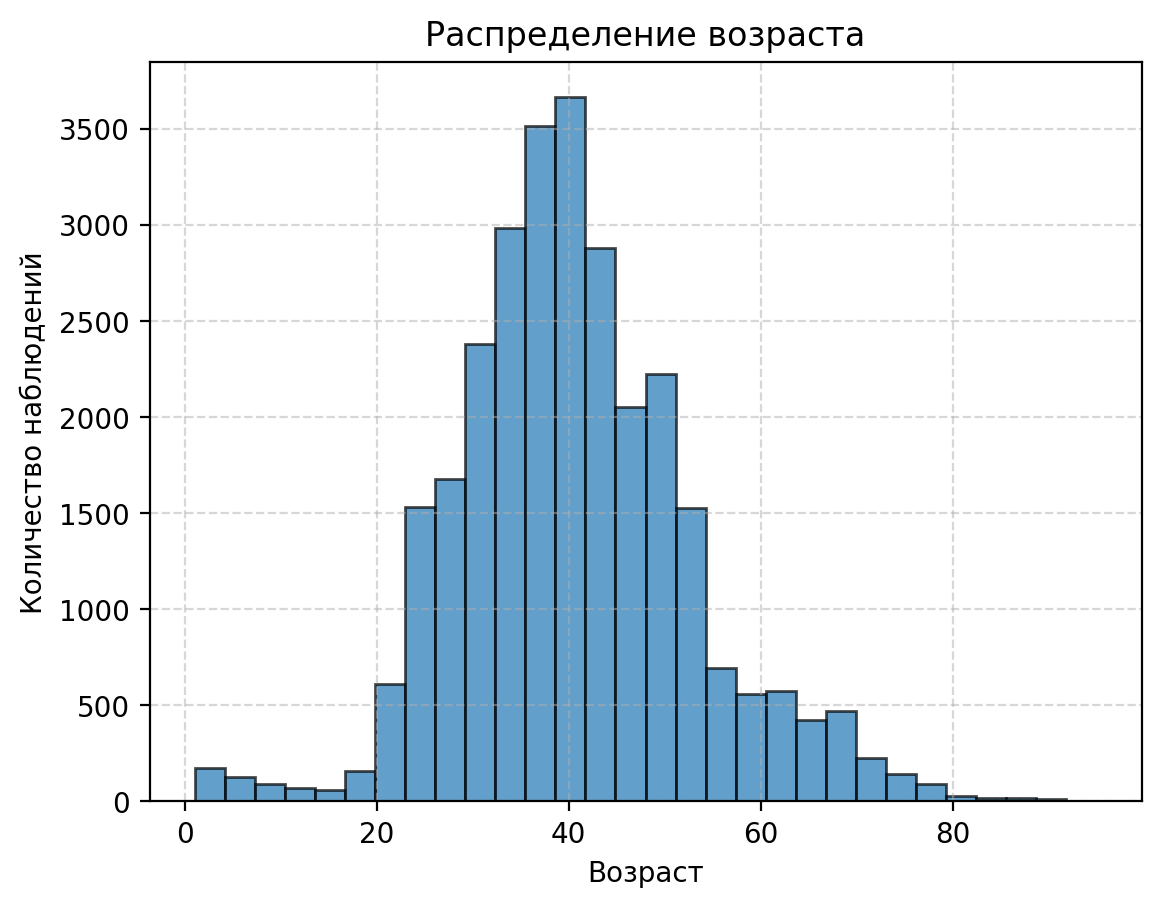

In [14]:
import matplotlib.pyplot as plt

# Рисуем гистограмму
plt.hist(data['age'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [20]:
df["article_id"].nunique()

3640

In [21]:
df["article_id"].value_counts()

article_id
5fe1ee71ca1d6006e262be11    39
628b9967bbd64f605e639ae2    38
5fa53a8919b05a79f9729c21    36
62a9f719ad21195610275454    35
62bd9b574a4176582f017bb2    34
                            ..
65f991fb262a2da6d403bb2a     1
60ee9991e55e8d55496a5cb2     1
660a7452ff818e788807a7ee     1
6606d8fcf6ca6f38e00baee4     1
62470462ca766a080e10dd32     1
Name: count, Length: 3640, dtype: int64

In [19]:
popular_ids = data['medialog_ehr_id'].value_counts()[lambda x: x > 200].index
filtered = data[data['medialog_ehr_id'].isin(popular_ids)]
filtered

,id,action_type,article_id,ehr_id,created_at,medialog_ehr_id,gender,age,birthday,title,url,views,published_date,formats,tags,rubric_title
11,3746911,CLICKED,60e814b22bf46615233e7a82,1032916,2023-07-01,1032916,1,54,1970-11-12,Почему от сережек болят мочки ушей,https://cuprum.media/science-answers/earrings?from=avaapp,1633.0,2021-07-09,longread,0,Ответили по науке
30,3751456,CLICKED,63d7e18af5fa57336b067842,1032916,2023-07-01,1032916,1,54,1970-11-12,Как проверять лекарства,https://cuprum.media/spravochnik/how-test-drugs?from=avaapp,4734.0,2023-01-30,longread,Лекарства,Справочник
35,3751987,CLICKED,5fa917d328d1c45d44585d41,1032916,2023-07-01,1032916,1,54,1970-11-12,Чек-лист для родителей детей с аутизмом,https://cuprum.media/razbor/autism-for-parents?from=avaapp,4556.0,2020-11-09,longread,"Обнаженные сердца,Ментальное",Разбор
84,3757255,CLICKED,62a21ea94b36f44b3a47ba52,1032916,2023-07-02,1032916,1,54,1970-11-12,"Как понять, что пора в отпуск",https://cuprum.media/lifestyle/need-a-vacation?from=avaapp,1597.0,2022-06-09,longread,Ментальное,Жизнь
87,3757461,CLICKED,624712b18fc1032e9353b256,1032916,2023-07-02,1032916,1,54,1970-11-12,Мазь «Спасатель» от чего-нибудь спасает?,https://cuprum.media/proverka-sluha/save-yourself?from=avaapp,3474.0,2022-04-01,longread,Булшит,Проверка слуха
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30307,9449140,CLICKED,5fd0bc3ecf5ea7565c0d2a71,1032916,2024-07-19,1032916,1,54,1970-11-12,Почему у меня диарея от стресса?,https://cuprum.media/stesnyayus-sprosit/anxious-gut?from=avaapp,12207.0,2020-12-09,longread,Кишечник,Стесняюсь спросить
30308,9449151,CLICKED,5fd0d444352333099f06b801,1032916,2024-07-19,1032916,1,54,1970-11-12,"Трудно быть врачом, работая участковым терапевтом",https://cuprum.media/interview/family-doctor?from=avaapp,5317.0,2020-12-09,interview,Поликлиника,Интервью
30309,9449360,CLICKED,6422fddccbf9eba01906ce02,1032916,2024-07-19,1032916,1,54,1970-11-12,Опасна ли простуда у беременных на раннем сроке,https://cuprum.media/science-answers/colds-in-early-pregnancy?from=avaapp,780.0,2023-03-28,longread,Беременность,Ответили по науке
30393,9472515,CLICKED,63ad525f745f99324f06f9b2,1032916,2024-07-20,1032916,1,54,1970-11-12,"Как понять, что врач — шарлатан",https://cuprum.media/science-answers/quack-doctor?from=avaapp,5120.0,2023-01-02,longread,"Диагностика,Метод лечения",Ответили по науке


In [10]:
data.возраст.describe()

count    30840.000000
mean        40.234565
std         12.186424
min          1.000000
25%         33.000000
50%         39.000000
75%         47.000000
max         95.000000
Name: возраст, dtype: float64

In [24]:
click_counts = df.groupby('ehr_id').size().reset_index(name='click_count')
click_counts['click_count'].value_counts().sort_index()


click_count
1      8444
2      2524
3       957
4       429
5       239
6       142
7        79
8        60
9        23
10       19
11       25
12        6
13       13
14        8
15        6
16        9
17        3
18        5
19        2
20        1
22        2
23        1
24        3
26        4
27        1
30        2
31        1
33        1
35        1
38        1
40        1
43        1
56        1
61        1
62        1
82        1
126       1
224       1
Name: count, dtype: int64

In [31]:
one_click_users = (click_counts['click_count'] == 1).sum()
many_click_users = (click_counts['click_count'] > 10).sum()

print(f"Пользователей с 1 кликом: {one_click_users}")
print(f"Пользователей с >10 кликов: {many_click_users}")

# Топ-10 активных
click_counts.sort_values('click_count', ascending=False).head(10)


Пользователей с 1 кликом: 8444
Пользователей с >10 кликов: 103


,ehr_id,click_count
5109,1032916,224
3454,753560,126
6934,1215515,82
1829,392196,62
11600,1382236,61
7729,1272945,56
10423,1344521,43
10037,1335829,40
3647,786594,38
1236,256458,35


# Выводы
- Всего есть 30000 событий
- 3703 уникальных статей
- Дубликатов не обнаружено
- Пропусков немного (130), но что есть - просто отсеяли
- Примерно 1000 событий в рубрике "Секс", потенциально убираем из датасета и не будем использовать в мобильном приложении
- 23778 событий "CLICK", используем только их ("Close" не используем)
- 13551 уникальных пользователей, почти все они есть в отфильтрованных данных по "Click"
- Распределение жен/муж - 18676/5102
- Большинство пользователей от 30 до 50 лет
- Начало событий: 2023-07-01 / Конец событий: 2024-07-30
- Очень иного пользователей только с 1 кликом (8444) и относительно небольшое количество с более чем 10 (вероятно это наши тестовые аккаунты или какие-то аномалии, нам они не помогут)